In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df=pd.read_csv('data.csv')
import pickle

In [34]:
data=df.to_numpy()

In [97]:
data1=data[:,0]
x=len(data1)
x

1297

In [98]:
seperations=[0]
for i in range(len(data1)-1):
    if (data1[i+1]-data1[i])>=500:
        seperations.append(i)
    else:
        pass
seperations.append(x)
seperations

[0,
 75,
 135,
 247,
 494,
 546,
 608,
 756,
 993,
 1122,
 1139,
 1166,
 1213,
 1247,
 1275,
 1297]

In [99]:
segments=[]
for i in range(len(seperations)-1):
    segments.append(data[(seperations[i]+3):(seperations[i+1]-3)])

In [100]:
def dx(i): return dat.x[i]-dat.x[i-1]
def dy(i): return dat.y[i]-dat.y[i-1]
def dt(i): return dat.time[i]-dat.time[i-1]
def theta(i):
    feature=0
    feature=math.atan2(dx(i+1)*dy(i)-dx(i)*dy(i+1),dx(i+1)*dx(i)+dy(i+1)*dy(i))
    return feature
def sigma(start, end, fun): return sum([fun(i) for i in range(start, end)])
def rf1(d): return (d.x[2]-d.x[0])/math.sqrt((d.y[2]-d.y[0])**2+(d.x[2]-d.x[0])**2)
def rf2(d): return (d.y[2]-d.y[0])/math.sqrt((d.y[2]-d.y[0])**2+(d.x[2]-d.x[0])**2)
def rf3(d): return math.sqrt((max(d.y)-min(d.y))**2+(max(d.x)-min(d.x))**2)
def rf4(d): return math.atan2(max(d.y)-min(d.y), max(d.x)-min(d.x))
def rf5(d): return math.sqrt((d.x[len(d)-1]-d.x[0])**2+(d.y[len(d)-1]-d.y[0])**2)
def rf6(d): return (d.x[len(d)-1]-d.x[0])/rf5(d)
def rf7(d): return (d.y[len(d)-1]-d.y[0])/rf5(d)
def rf8(d): return sigma(1, len(d), lambda i: math.sqrt(dx(i)**2+dy(i)**2))
def rf9(d): return sigma(1, len(d)-1, theta)
def rf10(d): return sigma(1, len(d)-1, lambda i: abs(theta(i)))
def rf11(d): return sigma(1, len(d)-1, lambda i: theta(i)**2)
def rf12(d): return max([(dx(i)**2+dy(i)**2)/dt(i)**2 if dt(i) > 0 else 0 for i in range(1, len(d))])
def rf13(d): return d.time[len(d)-1]-d.time[0]

In [101]:
len(segments)

15

In [102]:
df_list=[]
for i in segments:
    df_list.append(pd.DataFrame(i,columns=['time','x','y']))

In [103]:
stroke_features=[]
for i in range(len(df_list)):
    temp=[]
    dat=df_list[i]
    f1=rf1(df_list[i])
    f2=rf2(df_list[i])
    f3=rf3(df_list[i])
    f4=rf4(df_list[i])
    f5=rf5(df_list[i])
    f6=rf6(df_list[i])
    f7=rf7(df_list[i])
    f8=rf8(df_list[i])
    f9=rf9(df_list[i])
    f10=rf10(df_list[i])
    f11=rf11(df_list[i])
    f12=rf12(df_list[i])
    f13=rf13(df_list[i])
    temp+=[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13]
    stroke_features.append(temp)

In [104]:
df=pd.DataFrame(stroke_features,columns=['rf1','rf2','rf3','rf4','rf5','rf6','rf7','rf8','rf9','rf10','rf11','rf12','rf13'])

In [105]:
df

,rf1,rf2,rf3,rf4,rf5,rf6,rf7,rf8,rf9,rf10,rf11,rf12,rf13
0,1.000000,0.000000,631.202820,0.025351,631.087355,0.999862,-0.016638,632.086711,-2.775558e-17,2.580622,0.316353,2.070312,1135.0
1,0.000000,1.000000,135.592220,1.533913,135.592220,-0.036875,0.999320,135.932236,-5.551115e-17,1.297243,0.200503,0.169550,884.0
2,-0.970143,0.242536,114.865138,0.859337,3.041381,0.986394,-0.164399,259.028611,5.819538e+00,18.717652,8.043264,0.254883,1750.0
3,0.000000,1.000000,186.706320,0.677250,4.031129,0.496139,-0.868243,596.754967,-1.570796e+00,48.788471,45.477716,0.305664,4507.0
4,1.000000,0.000000,233.004828,0.006438,233.000536,0.999998,-0.002146,233.138235,4.163336e-17,0.496580,0.051668,0.346021,750.0
5,0.099504,0.995037,138.676782,1.520298,138.573085,-0.032474,0.999473,139.855964,-9.065989e-02,4.292378,1.483746,0.125433,962.0
6,1.000000,0.000000,199.323857,0.290015,8.631338,-0.984784,-0.173785,414.796735,3.141593e+00,26.074120,13.013633,0.249135,2403.0
7,0.164399,0.986394,252.325682,0.629233,6.964194,0.358979,-0.933346,660.461201,4.712389e+00,33.437270,24.400229,0.774414,3939.0
8,-0.983870,-0.178885,156.634128,0.796684,4.031129,0.992278,-0.124035,359.522463,6.480581e+00,19.305929,6.772051,0.225779,2037.0
9,0.989949,-0.141421,31.780497,0.222082,31.780497,0.975441,-0.220261,32.092527,4.636476e-01,1.517091,0.355943,0.200195,167.0


list

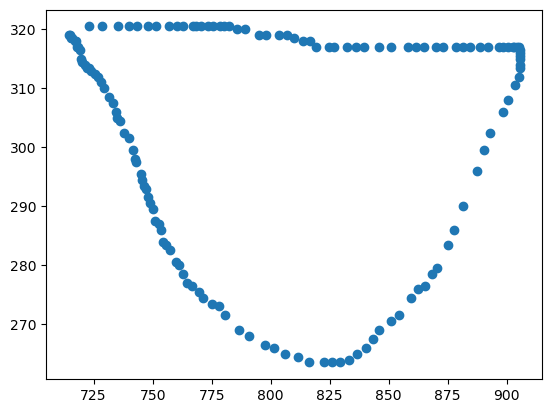

In [106]:
a=segments[6]
plt.scatter(a[:,1],a[:,2])
type(segments)

# Single Link Euclidean Distance between strokes

In [107]:
import math
def distance(u,v):
    minimum=[]
    min_d=[]
    u=np.array(u)
    v=np.array(v)
    u=np.delete(u,0,1)
    v=np.delete(v,0,1)
    for i in range(len(u)):
        for j in range(len(v)):
            d=math.dist(u[i],v[j])
            minimum.append(d)
        minimum.sort()
        minum=minimum[0]
        min_d.append(minum)
    min_d.sort()
    return min_d[0]
composite=[]
for i in range(len(segments)):
    un=segments[i]
    distarr=[]
    dist_index=[]
    for j in range(len(segments)):
        vn=segments[j]
        sldist=distance(un,vn)
        distarr.append(sldist)
        dist_index.append(j)
    matrix=np.array([dist_index,distarr])
    composite.append(matrix)

In [108]:
c=np.array(composite)
c

array([[[  0.        ,   1.        ,   2.        ,   3.        ,
           4.        ,   5.        ,   6.        ,   7.        ,
           8.        ,   9.        ,  10.        ,  11.        ,
          12.        ,  13.        ,  14.        ],
        [  0.        ,   8.84590301, 142.50350873,   8.51469318,
         154.65849476,  78.05767099, 131.70516315, 228.50054705,
         233.73328817, 290.5068846 , 284.30661266, 213.53746744,
         287.47391186, 286.63042407, 232.50053763]],

       [[  0.        ,   1.        ,   2.        ,   3.        ,
           4.        ,   5.        ,   6.        ,   7.        ,
           8.        ,   9.        ,  10.        ,  11.        ,
          12.        ,  13.        ,  14.        ],
        [  8.84590301,   0.        ,   2.        , 510.16296416,
         657.        , 579.38242983, 513.01973646, 247.59291185,
         312.16021527, 468.51600826, 542.37187427, 604.01179624,
         226.62799915, 159.57835066,  91.92388155]],

       [

# Distinguishing between line and non-line segments

In [109]:
line_arr=[]
obj_arr=[]
for i in range(len(stroke_features)):
    r=stroke_features[i]
    end_to_end=r[4]
    length=r[7]
    if end_to_end>=0.90*length:
        line_arr.append(i)
    else:
        obj_arr.append(i)
        pass
line_arr,obj_arr

([0, 1, 4, 5, 9, 10, 11, 12, 13, 14], [2, 3, 6, 7, 8])

In [122]:
dashed=[]
lines=[]
for i in line_arr:
    r=stroke_features[i]
    length=r[7]
    if length<=80:
        dashed.append(i)
    else:
        lines.append(i)
dashed,lines

([9, 10, 11, 12, 13, 14], [0, 1, 4, 5])

In [126]:
objects=[]
for i in obj_arr:
    objects.append(stroke_features[i])

df_obj=pd.DataFrame(objects,columns=['rf1','rf2','rf3','rf4','rf5','rf6','rf7','rf8','rf9','rf10','rf11','rf12','rf13'])
df_obj
model=pickle.load(open('RFC.sav','rb'))
y_pred=model.predict(df_obj)
y_pred
obj_dict={}
for i in range(len(obj_arr)):
    obj_dict[obj_arr[i]]=y_pred[i]
obj_dict

{2: 'Circle', 3: 'Valve ', 6: 'Semi (', 7: 'Square', 8: 'Circle'}

# Finding Circle in Square

In [116]:
minma=[]
for i in obj_arr:
    segs=np.array(segments[i])
    min_vals=np.amin(segs,0)
    max_vals=np.amax(segs,0)
    minma.extend([[min_vals[1],max_vals[1],min_vals[2],max_vals[2]]])

circle_in_square=[]
for i in range(0,len(minma)):
    minmax2=minma[i]
    minmax1=minma
    for j in range(0,len(minmax1)):
        if j==i:
            pass
        else:
            rfj=minmax1[j]
            if abs(minmax2[0]-rfj[0])<100:
                if abs(minmax2[1]-rfj[1])<100:
                    if abs(minmax2[2]-rfj[2])<100:
                        if abs(minmax2[3]-rfj[3])<100:
                            if i not in circle_in_square:
                                circle_in_square.append(i)
                                circle_in_square.append(j)

In [118]:
cont_objs=[]
for i in circle_in_square:
    cont_objs.append(obj_arr[i])
cont_objs

[7, 8]

# Determining Association through Euclidean Distance

In [200]:
sorted_neighbours=[]
for i in range(len(c)):
    a=c[i]
    xcalibre=np.argsort(a[1])
    xsorted=np.sort(a[1])
    xsorted=xsorted[xsorted<70.45]
    xsorted=xsorted[1:]
    xcalibre=xcalibre[1:len(xsorted)+1]
    sorted_neighbours.append(xcalibre)

In [201]:
xsorted,xcalibre

(array([ 3.        , 54.11330705]), array([ 2, 13], dtype=int64))

In [202]:
sorted_neighbours

[array([3, 1], dtype=int64),
 array([2, 0], dtype=int64),
 array([ 1, 14], dtype=int64),
 array([5, 4, 0], dtype=int64),
 array([3], dtype=int64),
 array([ 6,  3, 11], dtype=int64),
 array([ 5, 11], dtype=int64),
 array([ 8, 12,  9], dtype=int64),
 array([ 7,  9, 12], dtype=int64),
 array([ 7, 10,  8], dtype=int64),
 array([ 9, 11], dtype=int64),
 array([ 6,  5, 10], dtype=int64),
 array([ 7,  8, 13], dtype=int64),
 array([14, 12], dtype=int64),
 array([ 2, 13], dtype=int64)]

# Graph of connections

In [203]:
lines,dashed,obj_arr

([0, 1, 4, 5], [9, 10, 11, 12, 13, 14], [2, 3, 6, 7, 8])

In [204]:
lines_dict={}
for i in lines:
    lines_dict[i]='line'
dashed_dict={}
for i in dashed:
    dashed_dict[i]='dashed'
lines_dict,dashed_dict

({0: 'line', 1: 'line', 4: 'line', 5: 'line'},
 {9: 'dashed',
  10: 'dashed',
  11: 'dashed',
  12: 'dashed',
  13: 'dashed',
  14: 'dashed'})

In [205]:
lines_dict.update(dashed_dict)
lines_dict.update(obj_dict)
lines_dict

{0: 'line',
 1: 'line',
 4: 'line',
 5: 'line',
 9: 'dashed',
 10: 'dashed',
 11: 'dashed',
 12: 'dashed',
 13: 'dashed',
 14: 'dashed',
 2: 'Circle',
 3: 'Valve ',
 6: 'Semi (',
 7: 'Square',
 8: 'Circle'}

In [206]:
from collections import OrderedDict
stroke_dict=OrderedDict(sorted(lines_dict.items()))
align=list(stroke_dict.keys())

In [207]:
alignment_dict={}
for i in range(len(sorted_neighbours)):
    temp=[]
    xt=sorted_neighbours[i]
    for j in xt:
        temp.append(stroke_dict[j])
    alignment_dict[i]=temp

In [208]:
alignment_dict

{0: ['Valve ', 'line'],
 1: ['Circle', 'line'],
 2: ['line', 'dashed'],
 3: ['line', 'line', 'line'],
 4: ['Valve '],
 5: ['Semi (', 'Valve ', 'dashed'],
 6: ['line', 'dashed'],
 7: ['Circle', 'dashed', 'dashed'],
 8: ['Square', 'dashed', 'dashed'],
 9: ['Square', 'dashed', 'Circle'],
 10: ['dashed', 'dashed'],
 11: ['Semi (', 'line', 'dashed'],
 12: ['Square', 'Circle', 'dashed'],
 13: ['dashed', 'dashed'],
 14: ['Circle', 'dashed']}

In [212]:
for i in range(len(alignment_dict)):
    values_adjacent=alignment_dict[i]
    obj=lines_dict[i]
    if obj=='dashed':
        if 'line' in values_adjacent:
            values_adjacent.remove('line')
            alignment_dict[i]=values_adjacent
    if obj=='line':
        if 'dashed' in values_adjacent:
            values_adjacent.remove('dashed')
            alignment_dict[i]=values_adjacent

In [213]:
alignment_dict

{0: ['Valve ', 'line'],
 1: ['Circle', 'line'],
 2: ['line', 'dashed'],
 3: ['line', 'line', 'line'],
 4: ['Valve '],
 5: ['Semi (', 'Valve '],
 6: ['line', 'dashed'],
 7: ['Circle', 'dashed', 'dashed'],
 8: ['Square', 'dashed', 'dashed'],
 9: ['Square', 'dashed', 'Circle'],
 10: ['dashed', 'dashed'],
 11: ['Semi (', 'dashed'],
 12: ['Square', 'Circle', 'dashed'],
 13: ['dashed', 'dashed'],
 14: ['Circle', 'dashed']}